# Introduction to Data Science, CS 5963 / Math 3900
## Lecture 7: Logistic Regression

We introduce classification and logistic regression. 

Recommended Reading: ISLR, Ch.4 and Grus Ch. 16

In [1]:
import pandas as pd
import scipy as sc
import statsmodels.formula.api as sm

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

## Classification 

Recall that in **regression**, we try to predict a real-valued (quantitative) variable. Examples:
1. Predict house prices based on attributes
+ predict credit score rating based on income, balance, gender, education, etc...


In ** classification**, we try to predict a categorical (qualitative) variable. Examples:
1. Predict whether a bank should issue a persion a credit card (yes/no)
+ Predict a hospital patient's diagnosis (stroke, heart attack,...) based on symptoms. 

In the coming weeks, we'll see a variety of different classification methods:
1. logistic regression (today)
+ k nearest neighbors (Wednesday)
+ trees and random forests
+ support vector machines

**Setup:** Given $n$ samples $(x_1,y_1), (x_2,y_2),\ldots,(x_n,y_n)$, where $x_i$ are attributes or features and $y_i$ are categorical variables that you want to predict. 

**Example:** Hours studied vs passed exam? 

**Example:** We want to predict whether or not a student will be admitted to a graduate program based on their undergraduate performance (GPA, GRE score, prestige of student's undergraduate university). 

**Example:** The post office uses classification to automatically sort mail by zip code. Image processing tools are used to identify the zip code and then the digits are *classified* $0,1,2,\ldots,9$. 

** Evaluation:** How can we evaluate how well a classification algorithm has done? One way is via the confusion matrix. The *confusion matrix* is just a table where each column of the matrix represents the number of samples in each predicted class and each row represents the number of samples in each actual class. 

Consider the results from a classifier that is trying to classify 27 images of cats, dogs, and rabbits.
![title](ConfusionMatrix.png)
source: [wikipedia](https://en.wikipedia.org/wiki/Confusion_matrix)

This classifier is very good at distinguishing between cats and rabbits but lousy at recognizing dogs...half are misclassified!


## Logistic regression 

In logistic regression, the categorical value, $Y$, that we predict only takes two values. We'll call them 0 and 1. 

**Main idea:** Given the predictor variable  X, we model the *probability* that $Y = 1$ by 
$$
p(X) = p(Y = 1 | \ X) = \frac{e^{\beta_0 + \beta_1 X}}{1+ e^{\beta_0 + \beta_1 X}}
$$

The function on the right hand side can be written $\textrm{logistic}(\beta_0 + \beta_1 X)$ where the *logistic function* or *sigmoid function*,  
$$
\textrm{logistic}(x) := \frac{e^x}{1 + e^x} = \frac{1}{1+ e^{-x}}. 
$$
We can write the model succinctly as 
$$
p(X) = \textrm{logistic}( \beta_0 + \beta_1 X ).  
$$

One can check that the model is equivlant to 
$$
\log \left( \frac{p(X)}{1-p(X)} \right) = \beta_0 + \beta_1 X. 
$$


We interpret $\frac{p(X)}{1-p(X)}$ as being the *odds* that $Y=1$. Note that $p(X)$ is a number between 0 and 1 so that the odds that $Y=1$ is a number between 0 and $\infty$. If $p(X) = 0.5$, then odds = 1.  We also have that $\log \textrm{odds}$ is a number between $-\infty$ and $\infty$, so it makes sense that it could be linear in the data (as modeled). 

Sometimes, the function on the left hand side of is called the *logit function*, 
$$
\textrm{logit}(p) := \log \left( \frac{p}{1-p} \right). 
$$
We can equivalently write the model as 
$$
\textrm{logit} ( p(X) ) = \beta_0 + \beta_1 X.  
$$
It follows that the logistic and logit functions are inverses of each other. 

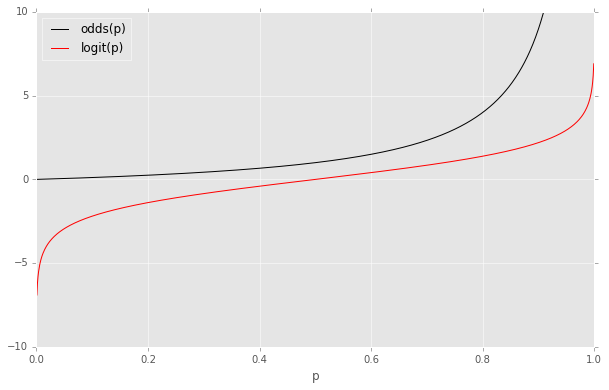

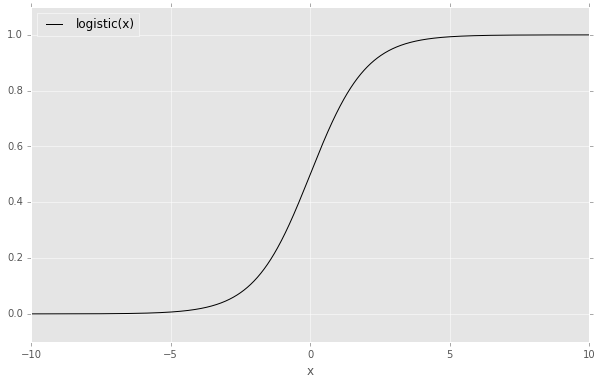

In [2]:
p = sc.linspace(0,1,1000)
odds = lambda p: p/(1-p)
logit = lambda p: sc.log(odds(p))
plt.plot(p,odds(p),color='Black',label='odds(p)')
plt.plot(p,logit(p),color='red',label='logit(p)')
plt.legend(loc='upper left')
plt.xlabel('p')
plt.ylim(-10,10)
plt.show()

x = sc.linspace(-10,10,1000)
logistic = lambda x: 1/(1+sc.exp(-x))
plt.plot(x,logistic(x),color='Black',label='logistic(x)')
plt.legend(loc='upper left')
plt.xlabel('x')
plt.ylim(-.1,1.1)
plt.show()

Recall that in linear regression, we found the the coefficients $\beta_0$ and $\beta_1$ by setting up the sum of the squared residuals $\sum_{i} (y_i - \beta_0 - \beta_1 x_i)^2$, setting the derivatives with respect to  $\beta_0$ and $\beta_1$ to zero, and solving for  $\hat \beta_0$ and $\hat \beta_1$. 
We can try to do the same thing here, but unlike linear regression, there is no longer a closed form solution for the best coefficients $\hat \beta_0$ and $\hat \beta_1$. We have to use a computer to find them. 

**Statistical inference viewpoint:** 
$$
y = \begin{cases}
1 &  \beta_0 + \beta_1 x + \epsilon > 0 \\
0 & \text{otherwise}
\end{cases}
$$
where $\epsilon$ is a random variable that is distributed according to the logistic distribution. 

## Logistic Regression Example:  How many hours do you need to study to pass the exam? 

This example was taken from [wikipedia](https://en.wikipedia.org/wiki/Logistic_regression). 

    hours  pass_exam
0    0.50          0
1    0.75          0
2    1.00          0
3    1.25          0
4    1.50          0
5    1.75          0
6    1.75          1
7    2.00          0
8    2.25          1
9    2.50          0
10   2.75          1
11   3.00          0
12   3.25          1
13   3.50          0
14   4.00          1
15   4.25          1
16   4.50          1
17   4.75          1
18   5.00          1
19   5.50          1


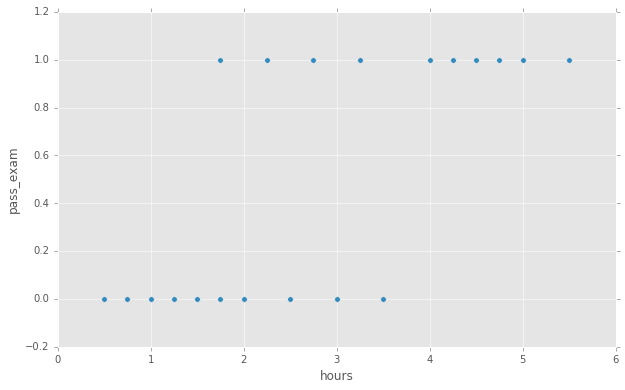

In [3]:
hours = [0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00, 3.25, 3.50, 4.00, 4.25, 4.50, 4.75, 5.00, 5.50] 
pass_Exam = [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
df = pd.DataFrame({"hours": hours, "pass_exam": pass_Exam})
print(df)

df.plot.scatter(x='hours',y='pass_exam',s=30)

For this example, we want to find coefficients $\beta_0$ and $\beta_1$ so that the model
$$
p(X) = \textrm{probability}(\textrm{passing} | \ \textrm{X hours studying} ) = \textrm{logistic}( \beta_0 + \beta_1 X )
$$
best explains the data. 

We can use the 'logit' function from the statsmodels python library. 

In [4]:
model = sm.logit(formula="pass_Exam ~ hours", data=df)
model_result = model.fit()
print(model_result.summary())

Optimization terminated successfully.
         Current function value: 0.401494
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              pass_Exam   No. Observations:                   20
Model:                          Logit   Df Residuals:                       18
Method:                           MLE   Df Model:                            1
Date:                Mon, 26 Sep 2016   Pseudo R-squ.:                  0.4208
Time:                        14:56:59   Log-Likelihood:                -8.0299
converged:                       True   LL-Null:                       -13.863
                                        LLR p-value:                 0.0006365
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -4.0777      1.761     -2.316      0.021        -7.529    -0.626
hours          1.5046      0.

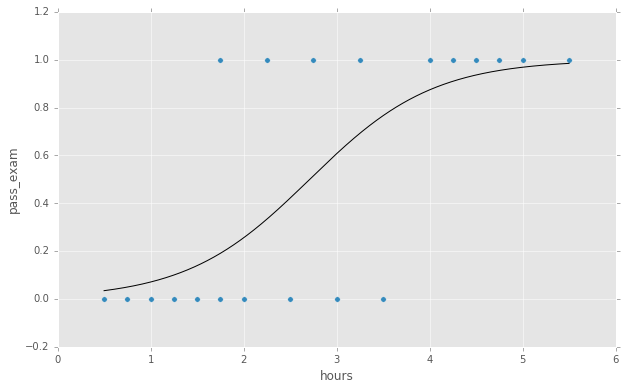

In [5]:
df.plot.scatter(x='hours',y='pass_exam',s=30)
x = sc.linspace(df['hours'].min(),df['hours'].max(),1000)
par = dict(model_result.params)
plt.plot(x,logistic(par['Intercept'] + par['hours']*x),color='Black')
plt.show()

The plot shows hours vs. whether or not the student passed and the logistic regression curve. The curve predicts the probability that a student will pass, given how many hours they've studied. 

From the plot, we can see that the more hours you spend studying, the more likely you are to pass the exam. *Let this be a lesson!* 

If I study just 2 hours, what is the likelihood that I'll pass? 

In [6]:
logistic(par['Intercept'] + par['hours']*2)

0.25570318264090985

After studying just 2 hours, I'm only $26\%$ likely to pass. 

How many hours do you have to study in order for the probability of passing to be greater than $50\%$?

From the plot, it looks like $\approx 2.75$ hours. How can we find this number from the logistic regression? 

In [7]:
prob_passing = 0.5
print((logit(prob_passing) - par['Intercept'])/par['hours'])

2.71008262425


We can also make a confusion matrix for the fit: 

In [8]:
df['pred_pass'] = model_result.predict()>.5
print(pd.crosstab(index=df["pass_exam"], columns=df["pred_pass"])) # confusion matrix

pred_pass  False  True 
pass_exam              
0              8      2
1              2      8


We interpret this as: for each category (pass,fail), there were two mistakenly classified points. 

## Logistic Regression Example: Graduate school admission based on undergraduate performance 

This example is based on [this blog post](http://blog.yhat.com/posts/logistic-regression-python-rodeo.html). 


**Dataset:**: For 400 students, we have the students attributes: GRE score, GPA, and the "prestige" of the student's undergraduate university (scale of 1 to 4, 1 best). We also have the variable that we want to predict: will they be accepted to grad school (yes/no)? 


In [9]:
df = pd.read_csv("http://www.ats.ucla.edu/stat/data/binary.csv")

# rename the 'rank' column because there is also a DataFrame method called 'rank'
df.columns = ["admit", "gre", "gpa", "prestige"]

#there are 400 students with 4 attributes: admit, gre, gpa, prestige
print(df.shape)
print(df[:10])


(400, 4)
   admit  gre   gpa  prestige
0      0  380  3.61         3
1      1  660  3.67         3
2      1  800  4.00         1
3      1  640  3.19         4
4      0  520  2.93         4
5      1  760  3.00         2
6      1  560  2.98         1
7      0  400  3.08         2
8      1  540  3.39         3
9      0  700  3.92         2


            admit         gre         gpa   prestige
count  400.000000  400.000000  400.000000  400.00000
mean     0.317500  587.700000    3.389900    2.48500
std      0.466087  115.516536    0.380567    0.94446
min      0.000000  220.000000    2.260000    1.00000
25%      0.000000  520.000000    3.130000    2.00000
50%      0.000000  580.000000    3.395000    2.00000
75%      1.000000  660.000000    3.670000    3.00000
max      1.000000  800.000000    4.000000    4.00000


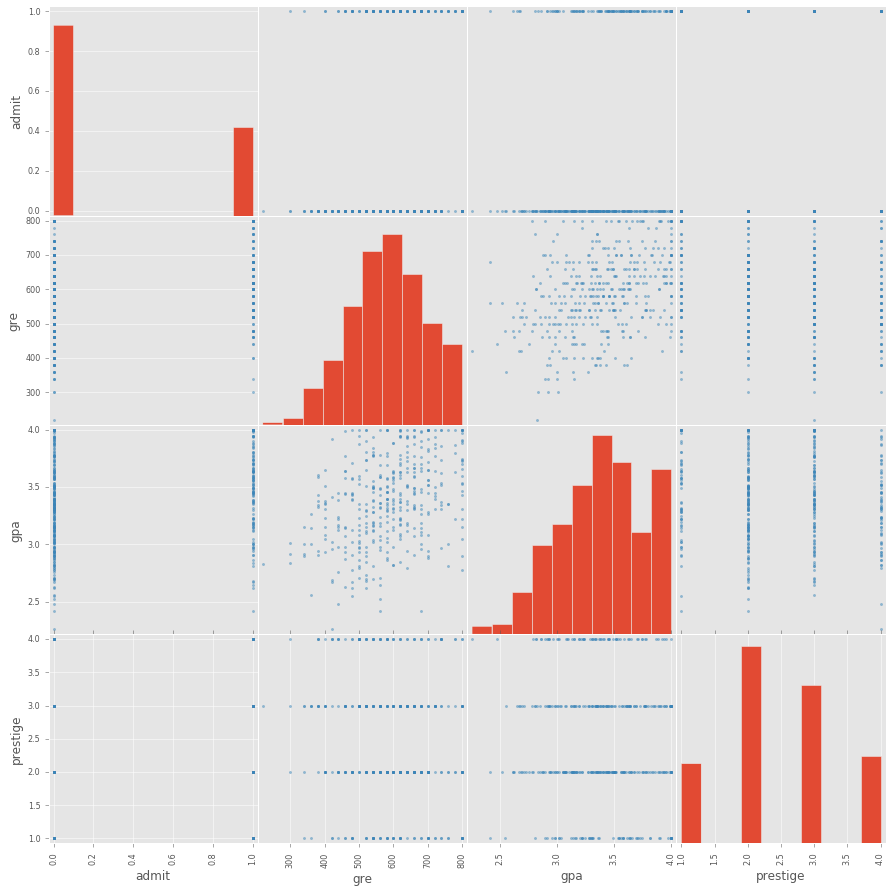

In [10]:
print(df.describe())
pd.scatter_matrix(df,figsize=(15, 15), diagonal='hist', color="#4682B4"); 

### First attempt at logistic regression
Let's first just focus on the GRE score. Our model is 
$$
\textrm{logit} ( \textrm{probability admittance} ) = \beta_0 + \beta_1 * \textrm{GRE}.  
$$

In [11]:
model = sm.logit(formula="admit ~ gre", data=df)
model_result = model.fit()
print(model_result.summary())

Optimization terminated successfully.
         Current function value: 0.607570
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      398
Method:                           MLE   Df Model:                            1
Date:                Mon, 26 Sep 2016   Pseudo R-squ.:                 0.02784
Time:                        14:57:02   Log-Likelihood:                -243.03
converged:                       True   LL-Null:                       -249.99
                                        LLR p-value:                 0.0001907
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -2.9013      0.606     -4.787      0.000        -4.089    -1.714
gre            0.0036      0.

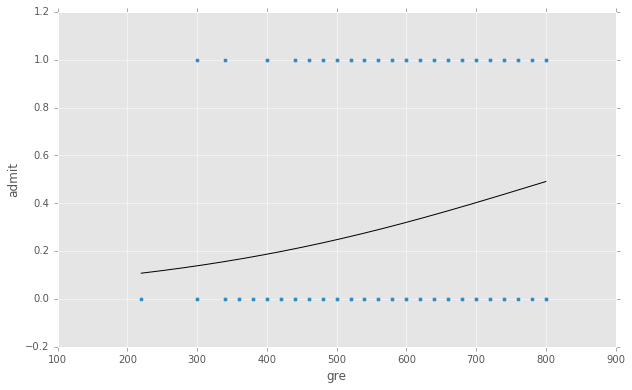

pred_admit_1  False
admit              
0               273
1               127


In [12]:
df.plot.scatter(x='gre',y='admit')

x = sc.linspace(df['gre'].min(),df['gre'].max(),1000)
par = dict(model_result.params)
plt.plot(x,logistic(par['Intercept'] + par['gre']*x),color='Black')
plt.show()

df['pred_admit_1'] = model_result.predict()>.5
print(pd.crosstab(index=df["admit"], columns=df["pred_admit_1"])) # confusion matrix

With only the GRE score, we basically just predict that everyone's probability of being admitted to graduate school $< 50\%$.  This is reflected in the confusion matrix. 

We need to include more data into our model! 

### Second attempt at logistic regression

Include both GPA and GRE scores. Our model is 
$$
\textrm{logit} ( \textrm{probability admittance} ) = \beta_0 + \beta_1 * \textrm{GRE} + \beta_2 * \textrm{GPA} .  
$$

In [13]:
model = sm.logit(formula="admit ~ gre + gpa", data=df)
model_result = model.fit()
print(model_result.summary())

df['pred_admit_2'] = model_result.predict()>.5
print(pd.crosstab(index=df["admit"], columns=df["pred_admit_2"])) # confusion matrix

Optimization terminated successfully.
         Current function value: 0.600430
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      397
Method:                           MLE   Df Model:                            2
Date:                Mon, 26 Sep 2016   Pseudo R-squ.:                 0.03927
Time:                        14:57:03   Log-Likelihood:                -240.17
converged:                       True   LL-Null:                       -249.99
                                        LLR p-value:                 5.456e-05
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -4.9494      1.075     -4.604      0.000        -7.057    -2.842
gre            0.0027      0.

We're still predicting that most students are not being admitted - still not a very good model. This isn't so surprising if we look at a plot of GPA vs. GRE and try to see which students are admitted. You can't tell with your eye, so it's not surprising that the model fails too. (This is generally a good check.) 

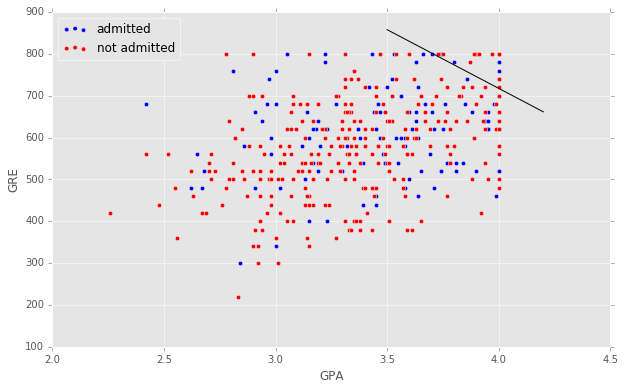

In [14]:
ax = df[df['admit']==1].plot.scatter(x='gpa',y='gre',color='blue',label='admitted')
df[df['admit']==0].plot.scatter(x='gpa',y='gre',color='red',label='not admitted',ax = ax)


x = sc.linspace(3.5,4.2,1000)
par = dict(model_result.params)
plt.plot(x,(1/par['gre'])*(logit(.5) - par['Intercept'] - par['gpa']*x),color='Black')

plt.xlabel('GPA')
plt.ylabel('GRE')
plt.legend(loc='upper left')
plt.show()


### Third attempt

Finally, we include the 'prestige' of the school as a predictor variable.

To get an idea of how many students are admitted from schools of different prestige, we can use the *crosstab* function in the pandas library. 

In [15]:
print(pd.crosstab(df['admit'], df['prestige'], rownames=['admit']) )

prestige   1   2   3   4
admit                   
0         28  97  93  55
1         33  54  28  12


We see that a smaller percentage of students are admitted from less prestigious universities. 

Recall that in linear regression, you can regress on ordinal variables by creating *dummy* variables (except baseline variable). We did this for the ethnicity variable in the credit dataset. One can similarly consider the prestige variable to be an ordinal variable and create a dummy variables...this is done [here](http://blog.yhat.com/posts/logistic-regression-python-rodeo.html) if you want to read about it. 

I found that the results are not much worse (and simpler) if we consider prestige to be an interval variable (equal increments between prestige levels). 

In [16]:
model = sm.logit(formula="admit ~ gre + gpa + prestige", data=df)
model_result = model.fit()
print(model_result.summary())

df['pred_admit_3'] = model_result.predict()>.5
print(pd.crosstab(index=df["admit"], columns=df["pred_admit_3"])) # confusion matrix

Optimization terminated successfully.
         Current function value: 0.574302
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      396
Method:                           MLE   Df Model:                            3
Date:                Mon, 26 Sep 2016   Pseudo R-squ.:                 0.08107
Time:                        14:57:03   Log-Likelihood:                -229.72
converged:                       True   LL-Null:                       -249.99
                                        LLR p-value:                 8.207e-09
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -3.4495      1.133     -3.045      0.002        -5.670    -1.229
gre            0.0023      0.

We're still now correctly predicting ($253/273=92\%$)  of the students who are not admitted. However, we're only correctly predicting ($29/127 = 23\%$) of the students who are admitted. 

**Moral:** GRE, gpa, and 'prestige' alone do not predict admittance to graduate school. 

